In [1]:
from pathlib import Path
import os
import sys

import matplotlib.pyplot as plt

main_directory = Path(os.path.abspath("")).parent
benchmark_directory = Path(main_directory, "experiment_scripts", "benchmarks")
sys.path.append(str(main_directory))

## Load The Benchmarking Results

In [2]:
from experiment_scripts.benchmark_result_serialization import ResultDecoder, VQABenchmarkResult, EVQEBenchmarkResult
from json import load

def load_benchmarking_results(algorithm: str, experiment_name: str):
    result_folder = Path(benchmark_directory, algorithm, experiment_name)
    
    result_dict: dict[int, dict[int, list]] = dict()
    
    size_folders = result_folder.glob("*")
    sizes = list(int(folder.stem) for folder in size_folders)
    
    for size in sizes:
        sub_dict = dict()
        
        instance_folders = result_folder.glob(f"{size}/*")
        instances = list(int(folder.stem) for folder in instance_folders)
        
        for instance in instances:
            result_list = []
            
            result_files = result_folder.glob(f"{size}/{instance}/*")
            for result in result_files:
                with open(result) as f:
                    result_list.append(load(f, cls=ResultDecoder))
            
            sub_dict[instance] = result_list
        
        result_dict[size] = sub_dict
            
    return result_dict

In [3]:
evqe_loaded = load_benchmarking_results("evqe", experiment_name="1905_1")
qaoa_loaded = load_benchmarking_results("qaoa", experiment_name="1805_1")
vqe_loaded = load_benchmarking_results("vqe", experiment_name="1905_1")

## Plot Raw Run History Data

In [4]:
from typing import Optional
from numpy import real

def plot_evqe_runhistory(loaded_results: list[EVQEBenchmarkResult], title: Optional[str] = None, valid_energy_level: Optional[float] = None, opt_energy_level: Optional[float] = None, log_scale: bool = False):
    
    for result in loaded_results:
        x = [sum(result.result.circuit_evaluations[:i+1]) for i in range(0, len(result.result.circuit_evaluations))]
        y = [real(x.best_expectation_value) for x in result.result.population_evaluation_results]
        plt.plot(x, y)
    
    plt.xlabel("Expectation Value Evaluations")
    plt.ylabel("Expectation Value")
    
    if title is not None:
        plt.title(title)
    
    if valid_energy_level is not None:
        plt.axhline(y=valid_energy_level, color="r")
    
    if opt_energy_level is not None:
        plt.axhline(y=opt_energy_level, color="b")
    
    if log_scale:
        plt.yscale("log")

In [5]:
def plot_vqa_runhistory(loaded_results: list[VQABenchmarkResult], title: Optional[str] = None, valid_energy_level: Optional[float] = None, opt_energy_level: Optional[float] = None, log_scale: bool = False, aggregate_n_steps: Optional[int] = None):
    for result in loaded_results:
        if aggregate_n_steps is None:
            x = result.expectation_evaluation_counts
            y = result.expectation_values
        else:
            x = result.expectation_evaluation_counts[::aggregate_n_steps]
            y = [min(result.expectation_values[i: i+aggregate_n_steps]) for i in list(range(0, len(result.expectation_values)))[::aggregate_n_steps]]
        plt.plot(x,y)
    
    plt.xlabel("Expectation Value Evaluations")
    plt.ylabel("Expectation Value")
    
    if title is not None:
        plt.title(title)
    
    if valid_energy_level is not None:
        plt.axhline(y=valid_energy_level, color='r')
    
    if opt_energy_level is not None:
        plt.axhline(y=opt_energy_level, color="b")
    
    if log_scale:
        plt.yscale("log")

In [6]:
val_energy = 100
opt_energy = real(evqe_loaded[15][6][0].max_opt_energy)

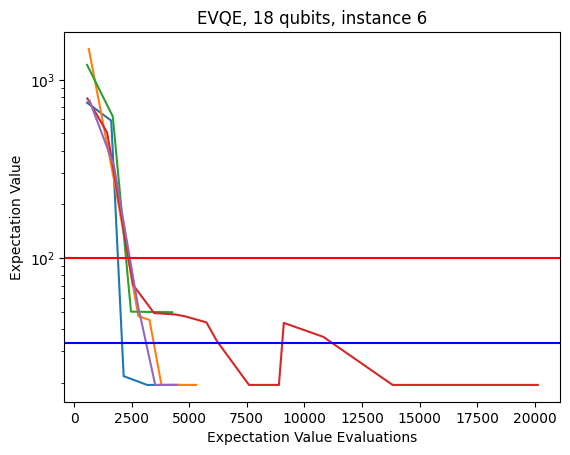

In [7]:
plottable_results = evqe_loaded[18][6]
plot_evqe_runhistory(plottable_results, title="EVQE, 18 qubits, instance 6", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy)

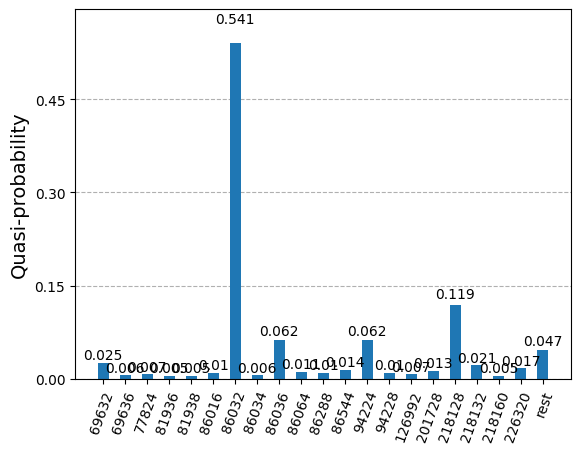

In [8]:
from qiskit.visualization import plot_histogram

eigenstate = plottable_results = evqe_loaded[18][6][0].result.eigenstate
plot_histogram(eigenstate, number_to_keep=20)

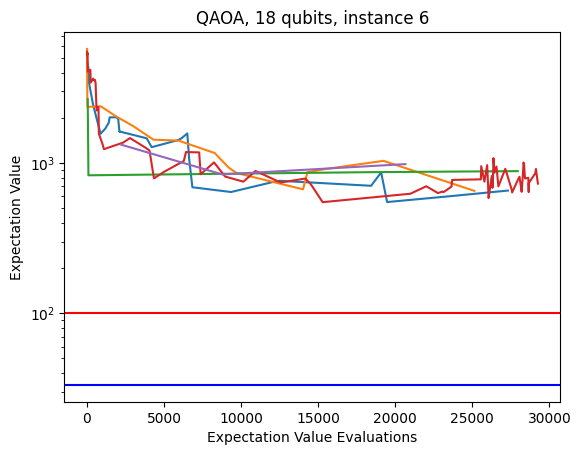

In [9]:
plottable_results = qaoa_loaded[18][6]
plot_vqa_runhistory(plottable_results, title="QAOA, 18 qubits, instance 6", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy)

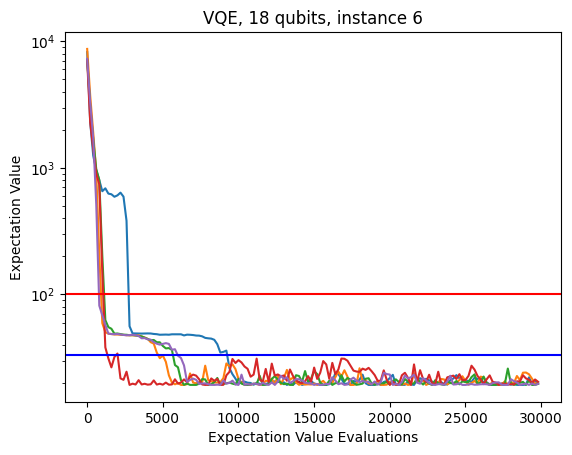

In [28]:
plottable_results = vqe_loaded[18][6]
plot_vqa_runhistory(plottable_results, title="VQE, 18 qubits, instance 6", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy, aggregate_n_steps=50)

## Plot Inter Instance Differences

In [11]:
from typing import Union

def get_p_opt(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> float:
    opt_makespan = result.optimal_makespan
    p_opt = 0
    
    if isinstance(result, VQABenchmarkResult):
        for state, prob in result.measurement_distribution.items():
            sol = result.state_translations[state]
            if sol.makespan is not None and sol.makespan == opt_makespan:
                p_opt += prob
    
    if isinstance(result, EVQEBenchmarkResult):
        for state, prob in result.result.eigenstate.items():
            sol = result.state_translations[state]
            if sol.makespan is not None and sol.makespan == opt_makespan:
                p_opt += prob
    
    return p_opt


def get_p_val(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> float:
    
    p_val = 0
    
    if isinstance(result, VQABenchmarkResult):
        for state, prob in result.measurement_distribution.items():
            sol = result.state_translations[state]
            if sol.is_valid:
                p_val += prob
    
    if isinstance(result, EVQEBenchmarkResult):
        for state, prob in result.result.eigenstate.items():
            sol = result.state_translations[state]
            if sol.is_valid:
                p_val += prob
    
    return p_val

In [12]:
def compare_instance_p_opts(results: dict[int, Union[VQABenchmarkResult, EVQEBenchmarkResult]]):
    for instance, instance_results in results.items():
        x = [instance]*len(instance_results)
        y = [get_p_opt(res) for res in instance_results]
        plt.scatter(x, y)
    plt.xticks(ticks=list(results.keys()), labels=[f"instance_{i}" for i in results.keys()])
    
    plt.xlabel("Problem Instance")
    plt.ylabel("Likelihood of an optimal Solution")

def compare_instance_p_vals(results: dict[int, Union[VQABenchmarkResult, EVQEBenchmarkResult]]):
    for instance, instance_results in results.items():
        x = [instance]*len(instance_results)
        y = [get_p_val(res) for res in instance_results]
        plt.scatter(x, y)
    plt.xticks(ticks=list(results.keys()), labels=[f"instance_{i}" for i in results.keys()])
    
    plt.xlabel("Problem Instance")
    plt.ylabel("Likelihood of a valid Solution")

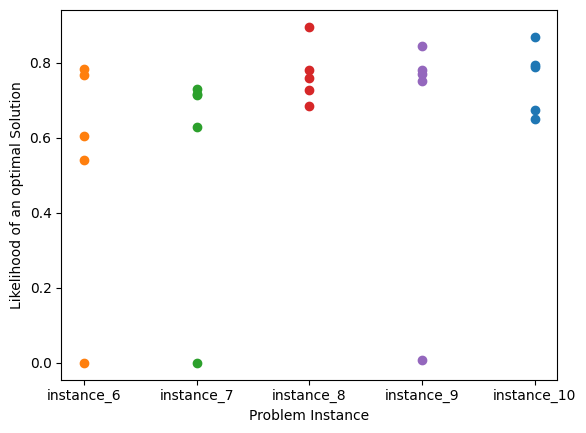

In [13]:
compare_instance_p_opts(evqe_loaded[18])

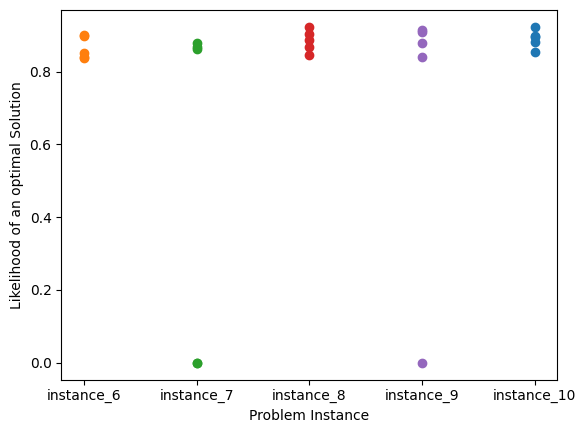

In [14]:
compare_instance_p_opts(vqe_loaded[18])

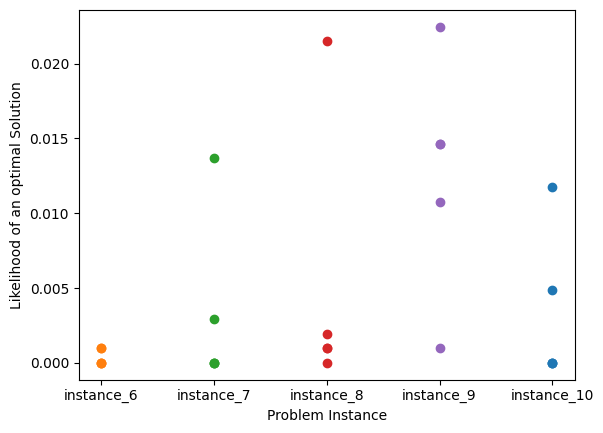

In [15]:
compare_instance_p_opts(qaoa_loaded[18])

In [16]:
def get_nexp_bounded(result: Union[VQABenchmarkResult, EVQEBenchmarkResult], bound: float):
    
    if isinstance(result, VQABenchmarkResult):
        indices = (i for i, val in enumerate(result.expectation_values) if val < bound)
        try:
            first = next(indices)
        except:
            return -1
        return result.expectation_evaluation_counts[first]
    
    if isinstance(result, EVQEBenchmarkResult):
        expectation_values = [r.best_expectation_value for r in result.result.population_evaluation_results]
        indices = (i for i, val in enumerate(expectation_values) if val < bound)
        try:
            first = next(indices)
        except:
            return -1
        return sum(result.result.circuit_evaluations[:first+1])

In [17]:
def compare_nexp_bounded(results: dict[int, Union[VQABenchmarkResult, EVQEBenchmarkResult]], bound: float, ylabel: Optional[str] = None):
    for instance, instance_results in results.items():
        x = [instance]*len(instance_results)
        y = [get_nexp_bounded(res, bound) for res in instance_results]
        plt.scatter(x, y)
    plt.xticks(ticks=list(results.keys()), labels=[f"instance_{i}" for i in results.keys()])
    
    plt.xlabel("Problem Instance")
    if ylabel is not None:
        plt.ylabel(ylabel)

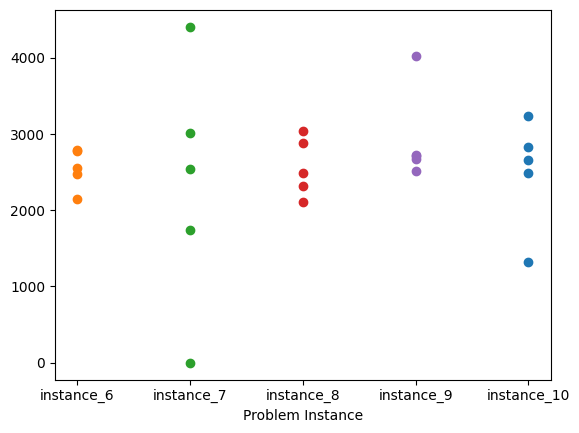

In [18]:
compare_nexp_bounded(evqe_loaded[18], 100)

## Compare Problem Sizes

In [21]:
from numpy import mean, quantile, median

def compare_pval_over_problem_sizes(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_p_val(res) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_p_val(res) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_p_val(res) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    fig, ax = plt.subplots()
    
    for problem_size in problem_sizes:
        evqemean = median(evqe_values[problem_size])
        lq, uq = quantile(evqe_values[problem_size], q=[0.25, 0.75])
        lq = evqemean - lq
        uq = uq - evqemean
        evqemin = min(evqe_values[problem_size])
        evqemax = max(evqe_values[problem_size])
        
        ax.errorbar(x=problem_size+evqe_offset, y=evqemean, yerr=[[lq], [uq]], fmt="o", mfc="b", mec="b", ecolor="b")
        
    
    for problem_size in problem_sizes:
        vqemean = median(vqe_values[problem_size])
        lq, uq = quantile(vqe_values[problem_size], q=[0.25, 0.75])
        lq = vqemean - lq
        uq = uq - vqemean
        evqemin = min(vqe_values[problem_size])
        evqemax = max(vqe_values[problem_size])
        
        ax.errorbar(x=problem_size+vqe_offset, y=vqemean, yerr=[[lq], [uq]], fmt="o", mfc="r", mec="r", ecolor="r")

    for problem_size in problem_sizes:
        qaoamean = median(qaoa_values[problem_size])
        lq, uq = quantile(qaoa_values[problem_size], q=[0.25, 0.75])
        lq = qaoamean - lq
        uq = uq - qaoamean
        evqemin = min(qaoa_values[problem_size])
        evqemax = max(qaoa_values[problem_size])
        
        ax.errorbar(x=problem_size+qaoa_offset, y=qaoamean, yerr=[[lq], [uq]], fmt="o", mfc="y", mec="y", ecolor="y")   
    
    ax.set_xticks(problem_sizes)

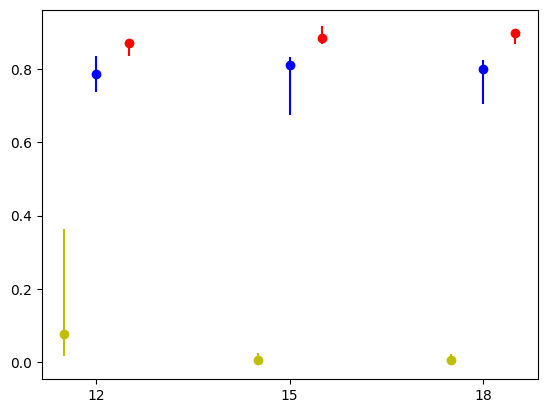

In [22]:
compare_pval_over_problem_sizes(evqe_loaded, vqe_loaded, qaoa_loaded, [12, 15, 18])

In [23]:
from numpy import mean, quantile

def compare_pval_over_problem_sizes_scatter(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_p_opt(res) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_p_opt(res) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_p_opt(res) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    for problem_size in problem_sizes:
        x = [problem_size+evqe_offset] * len(evqe_values[problem_size])
        plt.scatter(x, evqe_values[problem_size], c="b")
        
    
    for problem_size in problem_sizes:
        x = [problem_size+vqe_offset] * len(vqe_values[problem_size])
        plt.scatter(x, vqe_values[problem_size], c="r")

    for problem_size in problem_sizes:
        x = [problem_size+qaoa_offset] * len(qaoa_values[problem_size])
        plt.scatter(x, qaoa_values[problem_size], c="y")
    
    plt.xticks(problem_sizes)

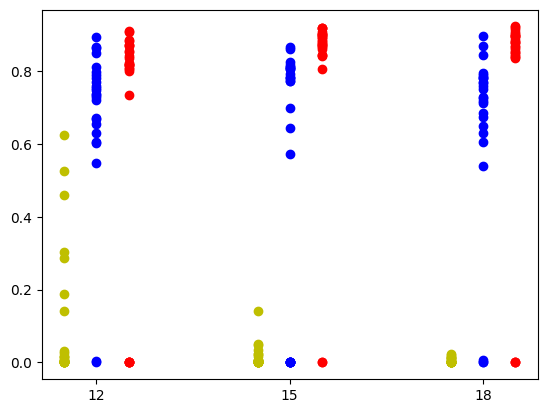

In [24]:
compare_pval_over_problem_sizes_scatter(evqe_loaded, vqe_loaded, qaoa_loaded, [12, 15, 18])

In [25]:
from numpy import mean, quantile

def compare_nexp_over_problem_sizes(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_nexp_bounded(res, 100) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_nexp_bounded(res, 100) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_nexp_bounded(res, 100) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    fig, ax = plt.subplots()
    
    for problem_size in problem_sizes:
        evqemean = median(evqe_values[problem_size])
        lq, uq = quantile(evqe_values[problem_size], q=[0.25, 0.75])
        lq = evqemean - lq
        uq = uq - evqemean
        evqemin = min(evqe_values[problem_size])
        evqemax = max(evqe_values[problem_size])
        
        ax.errorbar(x=problem_size+evqe_offset, y=evqemean, yerr=[[lq], [uq]], fmt="o", mfc="b", mec="b", ecolor="b")
        
    
    for problem_size in problem_sizes:
        vqemean = median(vqe_values[problem_size])
        lq, uq = quantile(vqe_values[problem_size], q=[0.25, 0.75])
        lq = vqemean - lq
        uq = uq - vqemean
        evqemin = min(vqe_values[problem_size])
        evqemax = max(vqe_values[problem_size])
        
        ax.errorbar(x=problem_size+vqe_offset, y=vqemean, yerr=[[lq], [uq]], fmt="o", mfc="r", mec="r", ecolor="r")

    for problem_size in problem_sizes:
        qaoamean = median(qaoa_values[problem_size])
        lq, uq = quantile(qaoa_values[problem_size], q=[0.25, 0.75])
        lq = qaoamean - lq
        uq = uq - qaoamean
        evqemin = min(qaoa_values[problem_size])
        evqemax = max(qaoa_values[problem_size])
        
        ax.errorbar(x=problem_size+qaoa_offset, y=qaoamean, yerr=[[lq], [uq]], fmt="o", mfc="y", mec="y", ecolor="y")   
    
    ax.set_xticks(problem_sizes)

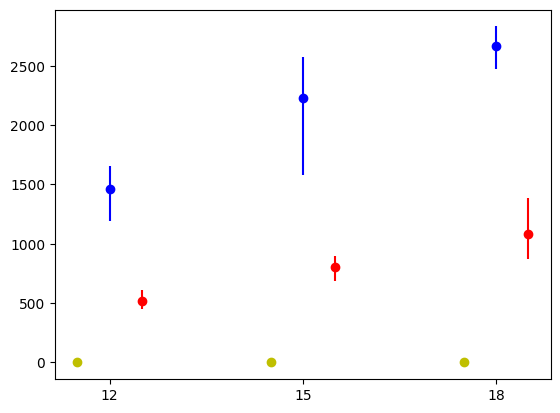

In [26]:
compare_nexp_over_problem_sizes(evqe_loaded, vqe_loaded, qaoa_loaded, [12, 15, 18])